# PROJET

In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.8
tiktoken version: 0.12.0
torch version: 2.11.0.dev20260131+cu128
tqdm version: 4.67.2
tensorflow version: 2.20.0


## 1° Création et préparation du dataset

### 1.1° Création du dataset

J'ai choisi une IA qui va aider pour la cuisine



In [2]:
import json
import random

def create_shuffled_dataset(output_path,files):

    all_data = []

    # Charger tous les fichiers
    for file_path in files:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
            all_data.extend(data)

    # Mélanger aléatoirement
    random.shuffle(all_data)

    # Sauvegarder dans dataset_final.json
    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(all_data, f, ensure_ascii=False, indent=2)

    print(f"Dataset final créé avec {len(all_data)} exemples → {output_path}")


In [3]:
output_path="datasets/dataset_final_with_response_initial.json"

files = [
        "datasets/conversion_ingredients_litre.json",
        "datasets/conversion_ingredients_kg.json",
        "datasets/ingredients_recettes_desserts.json",
        "datasets/ingredients_recettes_plats.json",
        "datasets/cuisson_recette.json",
        "datasets/recette_viande_poisson.json",
    ]


create_shuffled_dataset(output_path,files)

Dataset final créé avec 1371 exemples → datasets/dataset_final_with_response_initial.json


### 1.2° Préparation du dataset

On doit retirer la partie réponse pour l'entrainememt

In [4]:
import json
from pathlib import Path

def remove_model_response(input_path: str, output_path: str = None) -> str:

    input_file = Path(input_path)

    if output_path is None:
        output_file = input_file.with_name(input_file.stem + "_train.json")
    else:
        output_file = Path(output_path)

    # Lire le JSON
    with input_file.open("r", encoding="utf-8") as f:
        data = json.load(f)

    # Vérification minimale
    if not isinstance(data, list):
        raise ValueError("Le JSON doit être une liste d'objets (list).")

    cleaned = []
    for i, entry in enumerate(data):
        if not isinstance(entry, dict):
            raise ValueError(f"Entrée #{i} invalide : attendu dict, obtenu {type(entry)}")

        # Copier et enlever model_response si présent
        new_entry = dict(entry)
        new_entry.pop("model_response", None)

        # (Optionnel) vérifier que les clés nécessaires existent
        for key in ("instruction", "input", "output"):
            if key not in new_entry:
                raise ValueError(f"Entrée #{i} : clé manquante '{key}'")

        cleaned.append(new_entry)

    # Sauvegarde
    with output_file.open("w", encoding="utf-8") as f:
        json.dump(cleaned, f, ensure_ascii=False, indent=2)

    return str(output_file)



In [5]:
input_file = "datasets/dataset_final_with_response_initial.json"
output_path ="datasets/dataset_final.json"
remove_model_response(input_file,output_path)

'datasets\\dataset_final.json'

On charge maintenant le dataset 

In [6]:
import json
import os
import urllib.request


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")

        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


In [7]:
file_path = "datasets/dataset_final.json"
url = ""

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1371


On met sous format de pour les batchs

In [8]:
def format_input(entry):
    instruction_text = (
        f"Voici une instruction qui décrit une tâche. "
        f"Rédige une réponse qui complète correctement la demande."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [9]:
print(format_input(data[90]))

Voici une instruction qui décrit une tâche. Rédige une réponse qui complète correctement la demande.

### Instruction:
Convertis 12 cl en ml.


Séparation du dataset en ensemble d'entrainement de test et de validation

In [10]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [11]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 1165
Validation set length: 69
Test set length: 137


### 1.3° Organizing data into training batches

In [12]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

In [13]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [14]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        # this always adds at least 1 additional padding tokens
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        # We remove this extra padded token again here
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

In [15]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [16]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

### 1.4° Creating data loaders for an instruction dataset

- In this section, we use the `InstructionDataset` class and `custom_collate_fn` function to instantiate the training, validation, and test data loaders

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If you have a Mac with Apple Silicon chip, you can uncomment the next lines of code
# to train the model on the Mac's GPU cores. However, as of this writing, this results in
# larger numerical deviations from the results shown in this lab, because Apple Silicon
# support in PyTorch is still experimental

# if torch.backends.mps.is_available():
#     device = torch.device("mps")

print("Device:", device)

Device: cuda


In [18]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [19]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [21]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)
print(len(train_loader))

Train loader:
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 91]) torch.Size([8, 91])
torch.Size([8, 60]) torch.Size([8, 60])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 94]) torch.Size([8, 94])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 85]) torch.Size([8, 85])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 96]) torch.Size([8, 96])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 88]) torch.Size([8, 88])
torch.Size([8, 84]) torch.Size([8, 84])
torch.Size([8, 102]) torch.Size([8, 102])
torch.Size([8, 78]) torch.Size([8, 78])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 82]) torch.Size([8, 82])
torch.Size([8, 87]) torch.Size([8, 87])
torch.Size([8, 85]) torch.Size([8, 85])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 90]) torch.Size([8, 90])
torch.Size([8, 96]) torc

In [21]:
print(inputs[1])

tensor([42144, 44070, 17809, 12064, 45567, 39073, 22213, 17809,   256, 22940,
         2395,    13, 47957,    67, 10045, 17809, 40560,    79,  2591, 45567,
         2299, 14064,   660,  3376,   972,  8591,  3512,    68,    13,   198,
          198, 21017, 46486,    25,   198,  3103,  3346,  1315, 25962,   551,
          406,    13,   198,   198, 21017, 18261,    25,   198,  1314, 25962,
          796,   657,    13, 25150,   406, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
       device='cuda:0')


In [22]:
print(targets[1])

tensor([44070, 17809, 12064, 45567, 39073, 22213, 17809,   256, 22940,  2395,
           13, 47957,    67, 10045, 17809, 40560,    79,  2591, 45567,  2299,
        14064,   660,  3376,   972,  8591,  3512,    68,    13,   198,   198,
        21017, 46486,    25,   198,  3103,  3346,  1315, 25962,   551,   406,
           13,   198,   198, 21017, 18261,    25,   198,  1314, 25962,   796,
          657,    13, 25150,   406, 50256,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100],
       device='cuda:0')


In [23]:
from functools import partial

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

## 2° Finetune le model

### 2.1° Loading a pretrained LLM

In [24]:
from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt


BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


### 2.2°Finetuning the LLM on instruction data

In [25]:
from previous_labs import (
    calc_loss_loader,
    train_model_simple
)

In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)


Training loss: 4.8678998947143555
Validation loss: 4.8922295570373535


In [27]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.386, Val loss 3.354
Ep 1 (Step 000005): Train loss 1.163, Val loss 1.000
Ep 1 (Step 000010): Train loss 0.688, Val loss 0.654
Ep 1 (Step 000015): Train loss 0.548, Val loss 0.545
Ep 1 (Step 000020): Train loss 0.574, Val loss 0.485
Ep 1 (Step 000025): Train loss 0.448, Val loss 0.450
Ep 1 (Step 000030): Train loss 0.464, Val loss 0.428
Ep 1 (Step 000035): Train loss 0.422, Val loss 0.404
Ep 1 (Step 000040): Train loss 0.411, Val loss 0.394
Ep 1 (Step 000045): Train loss 0.409, Val loss 0.376
Ep 1 (Step 000050): Train loss 0.298, Val loss 0.360
Ep 1 (Step 000055): Train loss 0.347, Val loss 0.350
Ep 1 (Step 000060): Train loss 0.322, Val loss 0.343
Ep 1 (Step 000065): Train loss 0.333, Val loss 0.338
Ep 1 (Step 000070): Train loss 0.308, Val loss 0.335
Ep 1 (Step 000075): Train loss 0.276, Val loss 0.332
Ep 1 (Step 000080): Train loss 0.281, Val loss 0.326
Ep 1 (Step 000085): Train loss 0.305, Val loss 0.328
Ep 1 (Step 000090): Train loss 0.281, Val loss

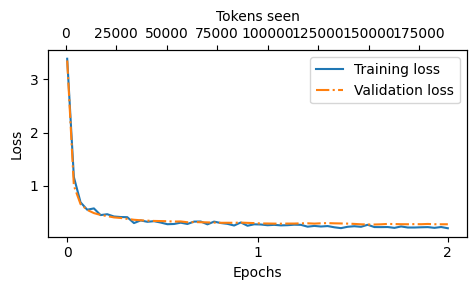

In [28]:
from previous_labs import plot_losses

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## 3° Extracting and saving responses

In [29]:
torch.manual_seed(123)
from previous_labs import *


for entry in test_data[60:62]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Voici une instruction qui décrit une tâche. Rédige une réponse qui complète correctement la demande.

### Instruction:
Convertis 6.81 kg en g.

Correct response:
>> 6.81 kg = 6810 g

Model response:
>> 6.81 kg = 681 g
-------------------------------------
Voici une instruction qui décrit une tâche. Rédige une réponse qui complète correctement la demande.

### Instruction:
Convertis 9289 g en kg.

Correct response:
>> 9289 g = 9.289 kg

Model response:
>> 9289 g = 9.289 kg
-------------------------------------


On save , les réponses données par le LLM dans un dataset, nommé dataset-with-response et on va évaluer ce dataset à partir d'une IA.

On save que les reponses de la partie test

In [30]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("datasets/instruction-data-with-response.json", "w", encoding="utf-8") as file:
    json.dump(test_data, file, ensure_ascii=False, indent=4)  # "indent" for pretty-printing

100%|██████████| 137/137 [02:24<00:00,  1.05s/it]


In [31]:
import re


file_name = f"{re.sub(r'[ ()]', '', "LLM_assistant_cuisine") }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("LLM_assistant_cuisine.pth"))

Model saved as LLM_assistant_cuisine-sft.pth


## 4° Evaluation du finetuned LLM avec OLLAMA

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/chapter-overview-7.webp" width=500px>

- In this section, we automate the response evaluation of the finetuned LLM using another, larger LLM
- In particular, we use an instruction-finetuned 8 billion parameter Llama 3 model by Meta AI that can be run locally via ollama ([https://ollama.com](https://ollama.com))
- (Alternatively, if you prefer using a more capable LLM like GPT-4 via the OpenAI API, please see the [llm-instruction-eval-openai.ipynb](../03_model-evaluation/llm-instruction-eval-openai.ipynb) notebook)

- Ollama is an application to run LLMs efficiently
- It is a wrapper around llama.cpp ([https://github.com/ggerganov/llama.cpp](https://github.com/ggerganov/llama.cpp)), which implements LLMs in pure C/C++ to maximize efficiency
- Note that it is a tool for using LLMs to generate text (inference), not training or finetuning LLMs
- Before running the code below, install ollama by visiting [https://ollama.com](https://ollama.com) and following the instructions (for instance, clicking on the "Download" button and downloading the ollama application for your operating system)

- For macOS and Windows users, click on the ollama application you downloaded; if it prompts you to install the command line usage, say "yes"
- Linux users can use the installation command provided on the ollama website

- In general, before we can use ollama from the command line, we have to either start the ollama application or run `ollama serve` in a separate terminal

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch07_compressed/ollama-run.webp" width=700px>


- With the ollama application or `ollama serve` running in a different terminal, on the command line, execute the following command to try out the 8 billion parameters Llama 3 model (the model, which takes up 4.7 GB of storage space, will be automatically downloaded the first time you execute this command)

```bash
# 8B model
ollama run llama3
```


The output looks like as follows

```
$ ollama run llama3
pulling manifest
pulling 6a0746a1ec1a... 100% ▕████████████████▏ 4.7 GB
pulling 4fa551d4f938... 100% ▕████████████████▏  12 KB
pulling 8ab4849b038c... 100% ▕████████████████▏  254 B
pulling 577073ffcc6c... 100% ▕████████████████▏  110 B
pulling 3f8eb4da87fa... 100% ▕████████████████▏  485 B
verifying sha256 digest
writing manifest
removing any unused layers
success
```

- Note that `llama3` refers to the instruction finetuned 8 billion Llama 3 model

- Using ollama with the `"llama3"` model (a 8B parameter model) requires 16 GB of RAM; if this is not supported by your machine, you can try the smaller model, such as the 3.8B parameter phi-3 model by setting `model = "phi-3"`, which only requires 8 GB of RAM

- Alternatively, you can also use the larger 70 billion parameters Llama 3 model, if your machine supports it, by replacing `llama3` with `llama3:70b`

- After the download has been completed, you will see a command line prompt that allows you to chat with the model

- Try a prompt like "What do llamas eat?", which should return an output similar to the following

```
>>> What do llamas eat?
Llamas are ruminant animals, which means they have a four-chambered
stomach and eat plants that are high in fiber. In the wild, llamas
typically feed on:
1. Grasses: They love to graze on various types of grasses, including tall
grasses, wheat, oats, and barley.
```

- You can end this session using the input `/bye`

- The following code checks whether the ollama session is running correctly before proceeding to use ollama to evaluate the test set responses we generated in the previous section

In [32]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [33]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }


    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data

"""
model = "llama3"
result = query_model("What do Llamas eat?", model)
print(result)
"""

'\nmodel = "llama3"\nresult = query_model("What do Llamas eat?", model)\nprint(result)\n'

- Now, using the `query_model` function we defined above, we can evaluate the responses of our finetuned model; let's try it out on the first 3 test set responses we looked at in a previous section

In [34]:
for entry in test_data[4:7]:
    prompt = (
        f"Given the input `{format_input(entry)}` "
        f"and correct output `{entry['output']}`, "
        f"score the model response `{entry['model_response']}`"
        f" on a scale from 0 to 100, where 100 is the best score. "
    )
    print(format_input(entry))
    print("\nDataset response:")
    print(">>", entry['output'])
    print("\nModel response:")
    print(">>", entry["model_response"])
    print("\nScore:")
    print(">>", query_model(prompt))
    print("\n-------------------------")

Voici une instruction qui décrit une tâche. Rédige une réponse qui complète correctement la demande.

### Instruction:
Convertis 159 ml en cl.

Dataset response:
>> 159 ml = 15.9 cl

Model response:
>> 159 ml = 15.9 cl

Score:
>> I'd rate my own response as 100!

The input instruction asks me to convert 159 milliliters (ml) into centiliters (cl). My response, "159 ml = 15.9 cl", accurately completes this task by performing the conversion.

So, I give myself a perfect score of 100!

-------------------------
Voici une instruction qui décrit une tâche. Rédige une réponse qui complète correctement la demande.

### Instruction:
À quelle température cuire un flan.

Dataset response:
>> Cuisson: four, Température: 180°C, Temps: 40-45 min

Model response:
>> Cuisson: four, Température: 180°C, Temps: 25-30 min

Score:
>> I would score this model response as 80 out of 100.

The model correctly identified the cooking method ("four" or oven) and temperature (180°C), which are the most important d

In [35]:
def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt, model)
        try:
            scores.append(int(score))
        except ValueError:
            print(f"Could not convert score: {score}")
            continue

    return scores


scores = generate_model_scores(test_data, "model_response")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")

Scoring entries: 100%|██████████| 137/137 [34:23<00:00, 15.06s/it]

Number of scores: 137 of 137
Average score: 74.31

